### Example Commands
#### ER
python utils/main.py --model er --dataset seq-clear10 --n_epochs 50 --lr 0.1 --batch_size 32 --minibatch_size 32 --buffer_size 500/1000 --nowand 1 --non_verbose 1 --ignore_other_metrics 1 --seed 42 --concept_drift -1/0 --n_drifts 1/2 --drift_adaptation 0/1/2

In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
import glob

# Functions

In [2]:
def read_results(path):
    with open(path, "r") as jsonfile:
        data = json.load(jsonfile)

    accuracy_array = data["task_accuracies"]
    max_len = 0
    for task_accuracy in accuracy_array:
        if len(task_accuracy) > max_len:
            max_len = len(task_accuracy)

    for task_accuracy in accuracy_array:
        for i in range(max_len - len(task_accuracy)):
            task_accuracy.append(0.0)

    accuracy_array = np.array(accuracy_array)
    accuracy_array[accuracy_array == 0.0] = np.nan

    for i, acc_array in enumerate(accuracy_array):
        for j in range(len(acc_array)):
            if i > 0 and np.isnan(acc_array[j]) and not np.isnan(accuracy_array[i - 1][j]):
                accuracy_array[i][j] = 0.0

    return accuracy_array

In [3]:
def average_forgetting(accuracy_arrays):
    T = accuracy_arrays.shape[0]  # Total number of tasks
    forgetting = []

    for t in range(T - 1):
        max_accuracy = np.nanmax(accuracy_arrays[:t + 1, t])
        final_accuracy = accuracy_arrays[T - 1, t]
        f_t = max_accuracy - final_accuracy
        forgetting.append(f_t)

    avg_forgetting = np.mean(forgetting) if forgetting else 0.0
    return forgetting, avg_forgetting

In [4]:
def cumulative_average_multiple_runs(pattern):
    cumulative_averages = []
    cumulative_forgetting = []
    log_files = glob.glob(pattern)
    if len(log_files) == 0:
        print("No files found")
        return 0
    print(f"{len(log_files)} files found")
    for i, log in enumerate(log_files):
        print(f"{i + 1}: {log}")
        task_accuracies = read_results(log)
        cum_avg = [np.nansum(task_accuracies[j]) / (j + 1) for j in range(len(task_accuracies))]
        cumulative_averages.append(cum_avg)
        _, avg_forgetting = average_forgetting(task_accuracies)
        cumulative_forgetting.append(avg_forgetting)
    print(f"FAA: {np.mean(cumulative_averages, axis=0)[-1]:.2f} ± {np.std(cumulative_averages, axis=0)[-1]:.2f}")
    print(f"Avg. Forgetting: {np.mean(cumulative_forgetting, axis=0):.2f} ± {np.std(cumulative_forgetting, axis=0):.2f}")

    return np.round(np.mean(cumulative_averages, axis=0), decimals=2).tolist()

In [5]:
def plot_results(accuracy_array, title="Accuracy over Tasks"):
    plt.figure(figsize=(12, 6))
    for i in range(len(accuracy_array)):
        plt.plot(
            range(1, len(accuracy_array) + 1),
            accuracy_array[:, i],
            "-o",
            label=f"Avg. Acc. After T{i + 1}: {np.nansum(accuracy_array[i])/(i+1):.2f}%",
        )
        for j, value in enumerate(accuracy_array[:, i]):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(12.5, 0),
                ha="center",
                fontsize=6
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_array) + 1))
    plt.yticks(list(range(0, 101, 5)))
    plt.legend(prop={"size": 6}, loc="lower left")

In [6]:
def plot_cumulative_results(title, accuracy_arrays, labels):

    assert len(accuracy_arrays) == len(
        labels
    ), "The number of accuracy arrays and labels must match."

    plt.figure(figsize=(12, 6))

    for idx, (cum_avg_acc, label) in enumerate(zip(accuracy_arrays, labels)):
        plt.plot(range(1, len(cum_avg_acc) + 1), cum_avg_acc, "--o" if idx == 0 else "-o", label=label)
        for j, value in enumerate(cum_avg_acc):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(
                    0,
                    -14 if (idx % 2) == 0 else 10,
                ),
                ha="center",
                fontsize=6,
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_arrays[0]) + 1))
    plt.yticks(list(range(0, 106, 5)))
    plt.legend(prop={"size": 12}, loc="lower left")
    plt.show()

In [7]:
def plot_cumulative_subplots(cumulative_averages, subtitles, labels, plot_filename=""):
    assert len(cumulative_averages) // 4 == len(
        subtitles
    ), "The number of methods and plot subtitles must match."

    colors = [
        "#1f77b4",
        "#d62728",
        "#ff7f0e",
        "#2ca02c",
    ]

    markers = ["--o", "-s", "-^", "-x"]

    fig, axes = plt.subplots(1, len(cumulative_averages) // 4, figsize=(15, 5))

    for i in range(len(cumulative_averages) // 4):
        for j in range(4):
            axes[i].plot(
                range(1, len(cumulative_averages[4 * i + j]) + 1),
                cumulative_averages[4 * i + j],
                markers[j],
                label=f"{labels[j]}",
                color=colors[j],
            )
            axes[i].grid(True, linewidth=0.3)
            axes[i].set_title(subtitles[i], fontsize=16)
            if i == 0: axes[i].legend(prop={"size": 12}, loc="lower left")
            axes[i].set_xticks(range(1, len(cumulative_averages[i]) + 1))
            axes[i].set_yticks(list(range(20, 101, 10)))

    fig.supxlabel("Task Trained On", fontsize=16)
    fig.supylabel("Accuracy (%)\n", fontsize=16)
    plt.tight_layout()
    if plot_filename != "" and len(plot_filename) > 0:
        plt.savefig(plot_filename, format="pdf", dpi=300)
    plt.show()

# ER

## Buffer 500

### Accuracy Without Drift

In [38]:
er_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./*-seq-clear10-er-buf-500-no-drift.json"
)

3 files found
1: ./02-04-26-20-01-14-seq-clear10-er-buf-500-no-drift.json
2: ./02-04-26-21-03-00-seq-clear10-er-buf-500-no-drift.json
3: ./02-04-26-18-59-39-seq-clear10-er-buf-500-no-drift.json
FAA: 36.40 ± 1.80
Avg. Forgetting: 70.38 ± 2.60


### Temporal Drift in Tasks 2, 4

In [39]:
er_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./*-seq-clear10-er-buf-500-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./02-04-26-23-06-26-seq-clear10-er-buf-500-drift-5-s-5-n-2-adaptation-0.json
2: ./02-04-26-22-04-38-seq-clear10-er-buf-500-drift-5-s-5-n-2-adaptation-0.json
3: ./02-05-26-00-08-10-seq-clear10-er-buf-500-drift-5-s-5-n-2-adaptation-0.json
FAA: 36.43 ± 1.13
Avg. Forgetting: 70.17 ± 0.29


### Temporal Drift in Tasks 2, 4 with Full Relearning

In [40]:
er_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./*-seq-clear10-er-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./02-05-26-05-01-00-seq-clear10-er-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./02-05-26-03-23-25-seq-clear10-er-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./02-05-26-01-45-52-seq-clear10-er-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 40.43 ± 1.47
Avg. Forgetting: 63.96 ± 1.80


### Temporal Drift in Tasks 2, 4 with Buffer Resampling

In [41]:
er_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./*-seq-clear10-er-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./02-05-26-07-05-57-seq-clear10-er-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./02-05-26-08-08-01-seq-clear10-er-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./02-05-26-06-03-34-seq-clear10-er-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 39.97 ± 0.42
Avg. Forgetting: 66.67 ± 0.62


### Cumulative Plots

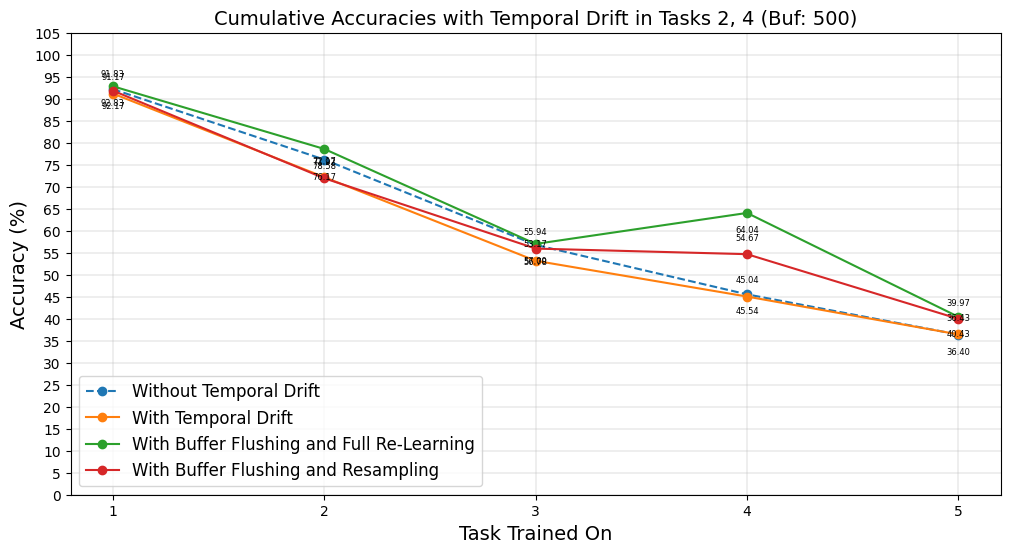

In [42]:
plot_cumulative_results(
    "Cumulative Accuracies with Temporal Drift in Tasks 2, 4 (Buf: 500)",
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Temporal Drift",
        "With Temporal Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 1000

### Accuracy Without Drift

In [8]:
er_1000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./rebuttal-logs/*-seq-clear10-er-buf-1000-no-drift.json"
)

3 files found
1: ./rebuttal-logs/02-05-26-13-33-40-seq-clear10-er-buf-1000-no-drift.json
2: ./rebuttal-logs/02-05-26-12-31-48-seq-clear10-er-buf-1000-no-drift.json
3: ./rebuttal-logs/02-05-26-14-35-12-seq-clear10-er-buf-1000-no-drift.json
FAA: 45.00 ± 1.15
Avg. Forgetting: 57.54 ± 0.62


### Temporal Drift in Tasks 2, 4

In [9]:
er_1000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./rebuttal-logs/*-seq-clear10-er-buf-1000-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./rebuttal-logs/02-05-26-17-40-31-seq-clear10-er-buf-1000-drift-5-s-5-n-2-adaptation-0.json
2: ./rebuttal-logs/02-05-26-15-36-59-seq-clear10-er-buf-1000-drift-5-s-5-n-2-adaptation-0.json
3: ./rebuttal-logs/02-05-26-16-38-58-seq-clear10-er-buf-1000-drift-5-s-5-n-2-adaptation-0.json
FAA: 44.33 ± 1.25
Avg. Forgetting: 51.92 ± 9.70


### Temporal Drift in Tasks 2, 4 with Full Relearning

In [10]:
er_1000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./rebuttal-logs/*-seq-clear10-er-buf-1000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./rebuttal-logs/02-05-26-20-55-44-seq-clear10-er-buf-1000-drift-5-s-5-n-2-adaptation-1.json
2: ./rebuttal-logs/02-05-26-19-18-06-seq-clear10-er-buf-1000-drift-5-s-5-n-2-adaptation-1.json
3: ./rebuttal-logs/02-05-26-22-33-18-seq-clear10-er-buf-1000-drift-5-s-5-n-2-adaptation-1.json
FAA: 47.53 ± 0.77
Avg. Forgetting: 52.92 ± 0.39


### Temporal Drift in Tasks 2, 4 with Buffer Resampling

In [11]:
er_1000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./rebuttal-logs/*-seq-clear10-er-buf-1000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./rebuttal-logs/02-06-26-01-39-42-seq-clear10-er-buf-1000-drift-5-s-5-n-2-adaptation-2.json
2: ./rebuttal-logs/02-06-26-00-37-47-seq-clear10-er-buf-1000-drift-5-s-5-n-2-adaptation-2.json
3: ./rebuttal-logs/02-05-26-23-35-33-seq-clear10-er-buf-1000-drift-5-s-5-n-2-adaptation-2.json
FAA: 51.50 ± 2.05
Avg. Forgetting: 50.33 ± 2.52


### Cumulative Plots

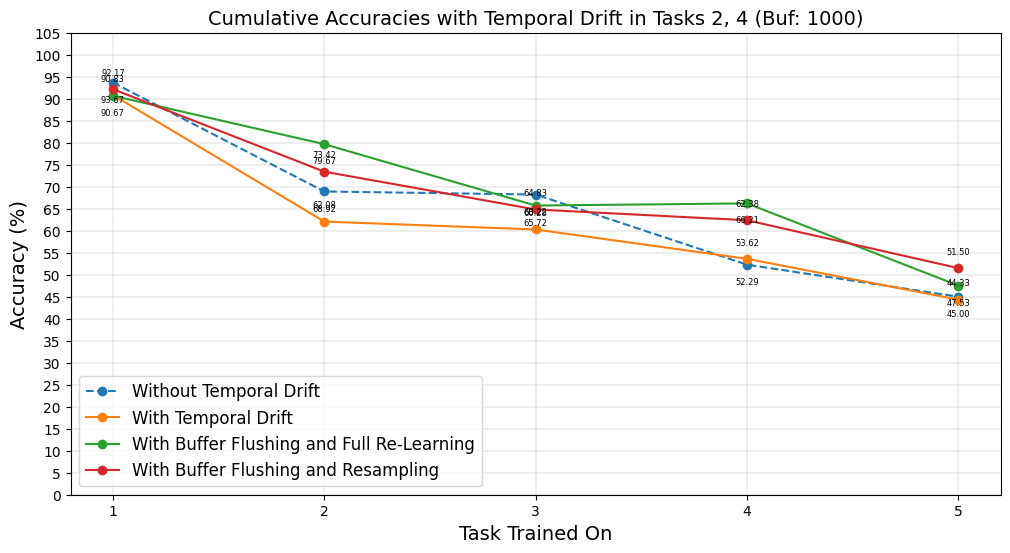

In [12]:
plot_cumulative_results(
    "Cumulative Accuracies with Temporal Drift in Tasks 2, 4 (Buf: 1000)",
    [
        er_1000_accuracy_array_without_drift,
        er_1000_accuracy_array_with_drift,
        er_1000_accuracy_array_with_drift_full_relearning,
        er_1000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Temporal Drift",
        "With Temporal Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

# ER-ACE

## Buffer 500

### Accuracy Without Drift

In [48]:
er_ace_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./*-seq-clear10-er_ace-buf-500-no-drift.json"
)

3 files found
1: ./02-04-26-19-50-47-seq-clear10-er_ace-buf-500-no-drift.json
2: ./02-04-26-18-56-14-seq-clear10-er_ace-buf-500-no-drift.json
3: ./02-04-26-20-45-21-seq-clear10-er_ace-buf-500-no-drift.json
FAA: 50.73 ± 3.06
Avg. Forgetting: 33.58 ± 1.12


### Temporal Drift in Tasks 2, 4

In [49]:
er_ace_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./*-seq-clear10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./02-04-26-22-34-46-seq-clear10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-0.json
2: ./02-04-26-23-29-36-seq-clear10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-0.json
3: ./02-04-26-21-40-06-seq-clear10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-0.json
FAA: 49.17 ± 0.63
Avg. Forgetting: 32.79 ± 5.10


### Temporal Drift in Tasks 2, 4 with Full Relearning

In [50]:
er_ace_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./*-seq-clear10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./02-05-26-03-59-59-seq-clear10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./02-05-26-01-00-04-seq-clear10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./02-05-26-02-30-12-seq-clear10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 59.27 ± 0.94
Avg. Forgetting: 26.42 ± 1.94


### Temporal Drift in Tasks 2, 4 with Buffer Resampling

In [51]:
er_ace_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./*-seq-clear10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./02-05-26-06-45-55-seq-clear10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./02-05-26-05-50-27-seq-clear10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./02-05-26-04-55-12-seq-clear10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 50.70 ± 0.94
Avg. Forgetting: 31.62 ± 2.27


### Cumulative Plots

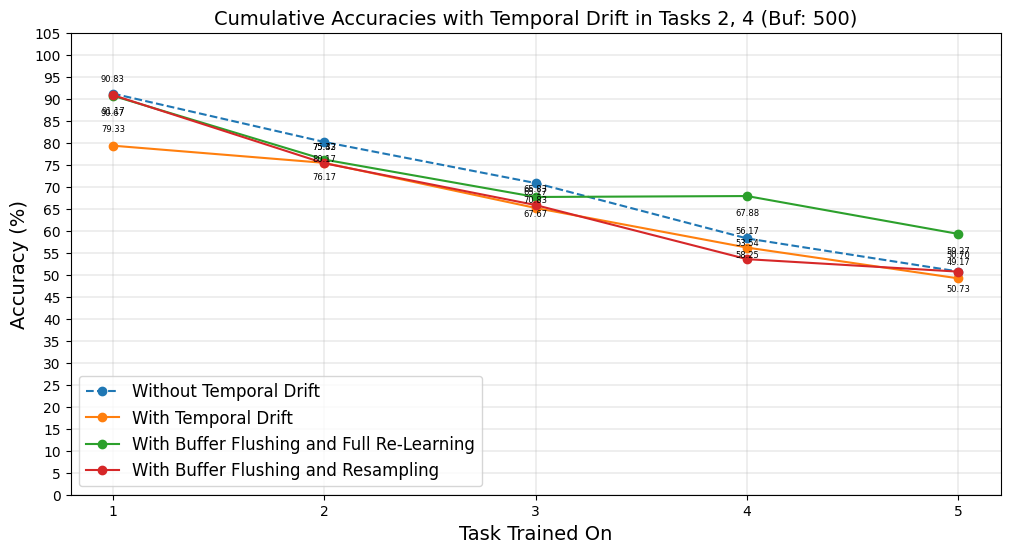

In [52]:
plot_cumulative_results(
    "Cumulative Accuracies with Temporal Drift in Tasks 2, 4 (Buf: 500)",
    [
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Temporal Drift",
        "With Temporal Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 1000

### Accuracy Without Drift

In [14]:
er_ace_1000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./rebuttal-logs/*-seq-clear10-er_ace-buf-1000-no-drift.json"
)

3 files found
1: ./rebuttal-logs/02-05-26-12-24-56-seq-clear10-er_ace-buf-1000-no-drift.json
2: ./rebuttal-logs/02-05-26-14-14-08-seq-clear10-er_ace-buf-1000-no-drift.json
3: ./rebuttal-logs/02-05-26-13-19-30-seq-clear10-er_ace-buf-1000-no-drift.json
FAA: 50.93 ± 1.19
Avg. Forgetting: 29.92 ± 0.56


### Temporal Drift in Tasks 2, 4

In [15]:
er_ace_1000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./rebuttal-logs/*-seq-clear10-er_ace-buf-1000-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./rebuttal-logs/02-05-26-16-03-17-seq-clear10-er_ace-buf-1000-drift-5-s-5-n-2-adaptation-0.json
2: ./rebuttal-logs/02-05-26-16-57-56-seq-clear10-er_ace-buf-1000-drift-5-s-5-n-2-adaptation-0.json
3: ./rebuttal-logs/02-05-26-15-08-40-seq-clear10-er_ace-buf-1000-drift-5-s-5-n-2-adaptation-0.json
FAA: 49.83 ± 1.14
Avg. Forgetting: 28.00 ± 4.56


### Temporal Drift in Tasks 2, 4 with Full Relearning

In [16]:
er_ace_1000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./rebuttal-logs/*-seq-clear10-er_ace-buf-1000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./rebuttal-logs/02-05-26-19-57-44-seq-clear10-er_ace-buf-1000-drift-5-s-5-n-2-adaptation-1.json
2: ./rebuttal-logs/02-05-26-21-27-56-seq-clear10-er_ace-buf-1000-drift-5-s-5-n-2-adaptation-1.json
3: ./rebuttal-logs/02-05-26-18-27-48-seq-clear10-er_ace-buf-1000-drift-5-s-5-n-2-adaptation-1.json
FAA: 59.33 ± 0.98
Avg. Forgetting: 25.92 ± 1.95


### Temporal Drift in Tasks 2, 4 with Buffer Resampling

In [17]:
er_ace_1000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./rebuttal-logs/*-seq-clear10-er_ace-buf-1000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./rebuttal-logs/02-06-26-00-14-04-seq-clear10-er_ace-buf-1000-drift-5-s-5-n-2-adaptation-2.json
2: ./rebuttal-logs/02-05-26-23-18-40-seq-clear10-er_ace-buf-1000-drift-5-s-5-n-2-adaptation-2.json
3: ./rebuttal-logs/02-05-26-22-23-20-seq-clear10-er_ace-buf-1000-drift-5-s-5-n-2-adaptation-2.json
FAA: 53.00 ± 0.59
Avg. Forgetting: 28.96 ± 1.71


### Cumulative Plots

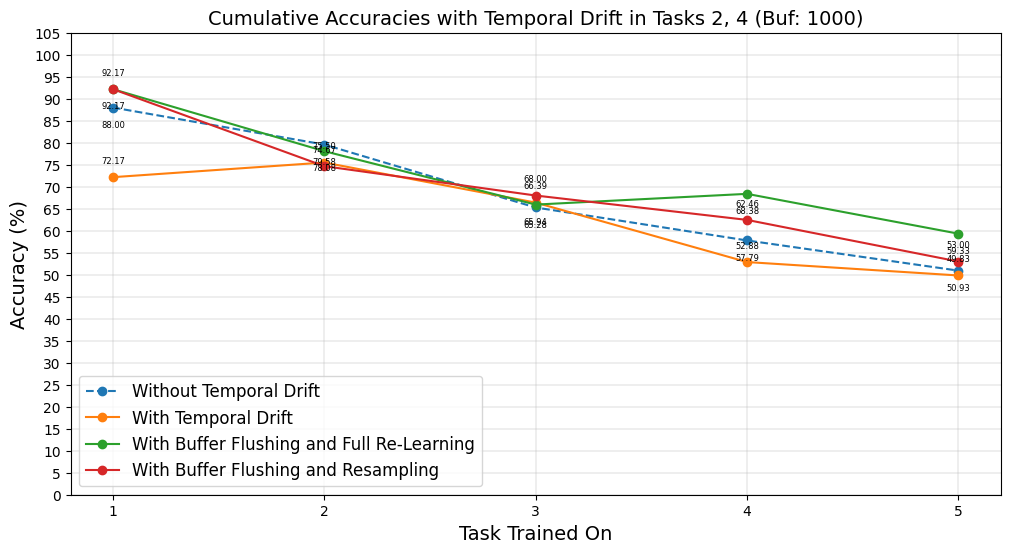

In [18]:
plot_cumulative_results(
    "Cumulative Accuracies with Temporal Drift in Tasks 2, 4 (Buf: 1000)",
    [
        er_ace_1000_accuracy_array_without_drift,
        er_ace_1000_accuracy_array_with_drift,
        er_ace_1000_accuracy_array_with_drift_full_relearning,
        er_ace_1000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Temporal Drift",
        "With Temporal Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

# CLSER

## Buffer 500

### Accuracy Without Drift

In [58]:
clser_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./*-seq-clear10-clser-buf-500-no-drift.json"
)

3 files found
1: ./02-04-26-19-53-59-seq-clear10-clser-buf-500-no-drift.json
2: ./02-04-26-21-39-38-seq-clear10-clser-buf-500-no-drift.json
3: ./02-04-26-23-25-25-seq-clear10-clser-buf-500-no-drift.json
FAA: 35.43 ± 2.90
Avg. Forgetting: 68.42 ± 4.66


### Temporal Drift in Tasks 2, 4

In [59]:
clser_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./*-seq-clear10-clser-buf-500-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./02-05-26-04-42-46-seq-clear10-clser-buf-500-drift-5-s-5-n-2-adaptation-0.json
2: ./02-05-26-02-57-04-seq-clear10-clser-buf-500-drift-5-s-5-n-2-adaptation-0.json
3: ./02-05-26-01-11-10-seq-clear10-clser-buf-500-drift-5-s-5-n-2-adaptation-0.json
FAA: 39.43 ± 0.68
Avg. Forgetting: 64.33 ± 0.95


### Temporal Drift in Tasks 2, 4 with Full Relearning

In [60]:
clser_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./*-seq-clear10-clser-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./02-05-26-13-05-27-seq-clear10-clser-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./02-05-26-07-30-59-seq-clear10-clser-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./02-05-26-10-18-28-seq-clear10-clser-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 48.37 ± 1.89
Avg. Forgetting: 48.08 ± 1.47


### Temporal Drift in Tasks 2, 4 with Buffer Resampling

In [61]:
clser_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./*-seq-clear10-clser-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./02-05-26-18-24-22-seq-clear10-clser-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./02-05-26-16-37-53-seq-clear10-clser-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./02-05-26-14-51-39-seq-clear10-clser-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 45.50 ± 2.49
Avg. Forgetting: 57.33 ± 3.93


### Cumulative Plots

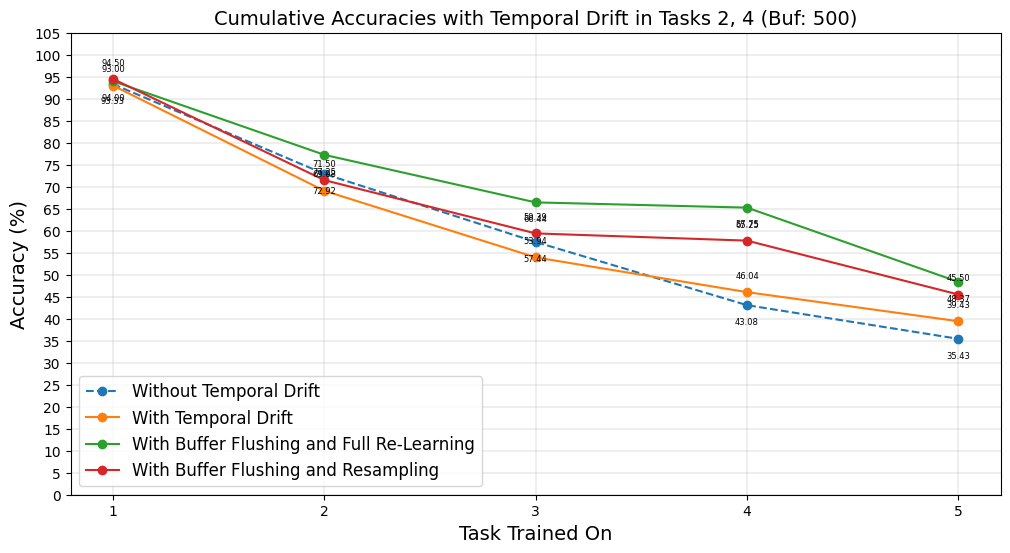

In [62]:
plot_cumulative_results(
    "Cumulative Accuracies with Temporal Drift in Tasks 2, 4 (Buf: 500)",
    [
        clser_500_accuracy_array_without_drift,
        clser_500_accuracy_array_with_drift,
        clser_500_accuracy_array_with_drift_full_relearning,
        clser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Temporal Drift",
        "With Temporal Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 1000

### Accuracy Without Drift

In [19]:
clser_1000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./rebuttal-logs/*-seq-clear10-clser-buf-1000-no-drift.json"
)

3 files found
1: ./rebuttal-logs/02-05-26-14-53-27-seq-clear10-clser-buf-1000-no-drift.json
2: ./rebuttal-logs/02-05-26-16-39-36-seq-clear10-clser-buf-1000-no-drift.json
3: ./rebuttal-logs/02-05-26-18-25-56-seq-clear10-clser-buf-1000-no-drift.json
FAA: 47.37 ± 0.29
Avg. Forgetting: 53.62 ± 0.44


### Temporal Drift in Tasks 2, 4

In [20]:
clser_1000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./rebuttal-logs/*-seq-clear10-clser-buf-1000-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./rebuttal-logs/02-05-26-21-58-29-seq-clear10-clser-buf-1000-drift-5-s-5-n-2-adaptation-0.json
2: ./rebuttal-logs/02-05-26-23-44-30-seq-clear10-clser-buf-1000-drift-5-s-5-n-2-adaptation-0.json
3: ./rebuttal-logs/02-05-26-20-12-26-seq-clear10-clser-buf-1000-drift-5-s-5-n-2-adaptation-0.json
FAA: 46.47 ± 0.74
Avg. Forgetting: 55.12 ± 1.91


### Temporal Drift in Tasks 2, 4 with Full Relearning

In [21]:
clser_1000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./rebuttal-logs/*-seq-clear10-clser-buf-1000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./rebuttal-logs/02-06-26-05-20-41-seq-clear10-clser-buf-1000-drift-5-s-5-n-2-adaptation-1.json
2: ./rebuttal-logs/02-06-26-02-32-05-seq-clear10-clser-buf-1000-drift-5-s-5-n-2-adaptation-1.json
3: ./rebuttal-logs/02-06-26-08-09-09-seq-clear10-clser-buf-1000-drift-5-s-5-n-2-adaptation-1.json
FAA: 55.27 ± 3.00
Avg. Forgetting: 38.00 ± 3.63


### Temporal Drift in Tasks 2, 4 with Buffer Resampling

In [22]:
clser_1000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./rebuttal-logs/*-seq-clear10-clser-buf-1000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./rebuttal-logs/02-06-26-09-56-21-seq-clear10-clser-buf-1000-drift-5-s-5-n-2-adaptation-2.json
2: ./rebuttal-logs/02-06-26-13-30-36-seq-clear10-clser-buf-1000-drift-5-s-5-n-2-adaptation-2.json
3: ./rebuttal-logs/02-06-26-11-43-27-seq-clear10-clser-buf-1000-drift-5-s-5-n-2-adaptation-2.json
FAA: 55.30 ± 3.13
Avg. Forgetting: 42.92 ± 4.53


### Cumulative Plots

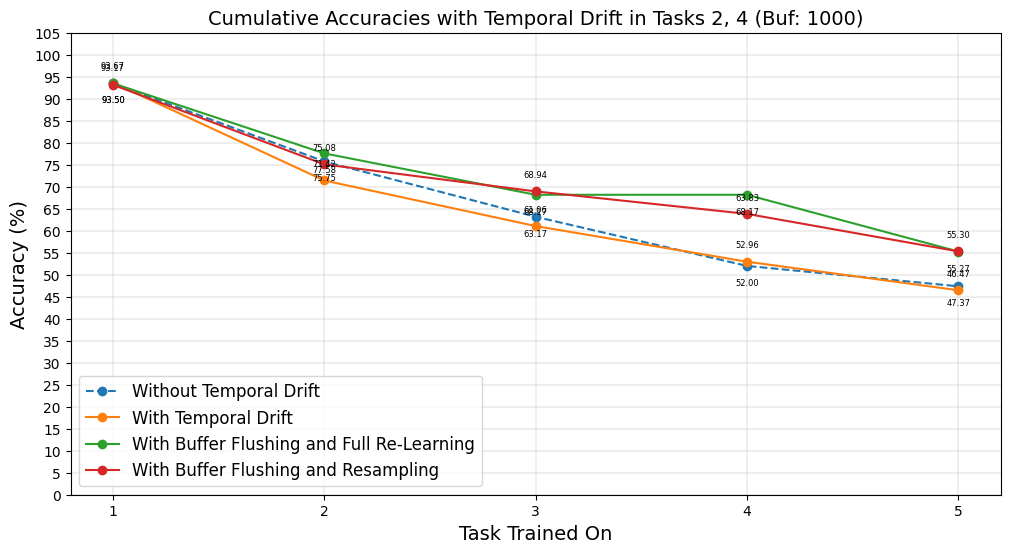

In [23]:
plot_cumulative_results(
    "Cumulative Accuracies with Temporal Drift in Tasks 2, 4 (Buf: 1000)",
    [
        clser_1000_accuracy_array_without_drift,
        clser_1000_accuracy_array_with_drift,
        clser_1000_accuracy_array_with_drift_full_relearning,
        clser_1000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Temporal Drift",
        "With Temporal Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

# Comparisons

## Buffer 500

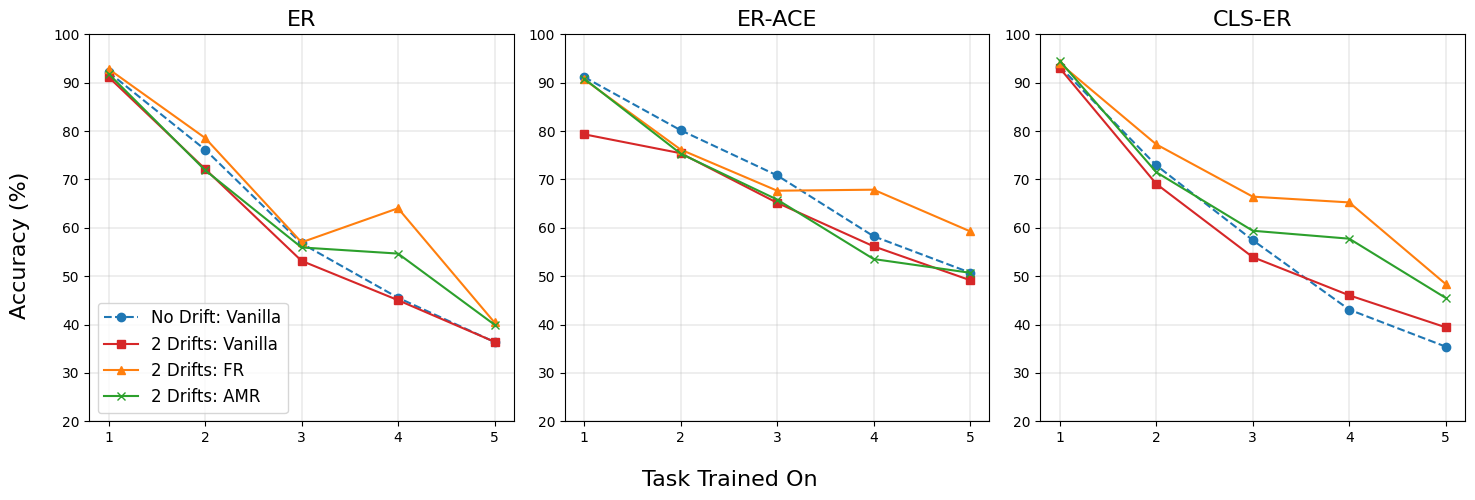

In [68]:
plot_cumulative_subplots(
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
        clser_500_accuracy_array_without_drift,
        clser_500_accuracy_array_with_drift,
        clser_500_accuracy_array_with_drift_full_relearning,
        clser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    ["ER", "ER-ACE", "CLS-ER"],
    [
        "No Drift: Vanilla",
        "2 Drifts: Vanilla",
        "2 Drifts: FR",
        "2 Drifts: AMR",
    ],
    # plot_filename="CLEAR10_Buff_500_n_2.pdf",
)

## Buffer 1000

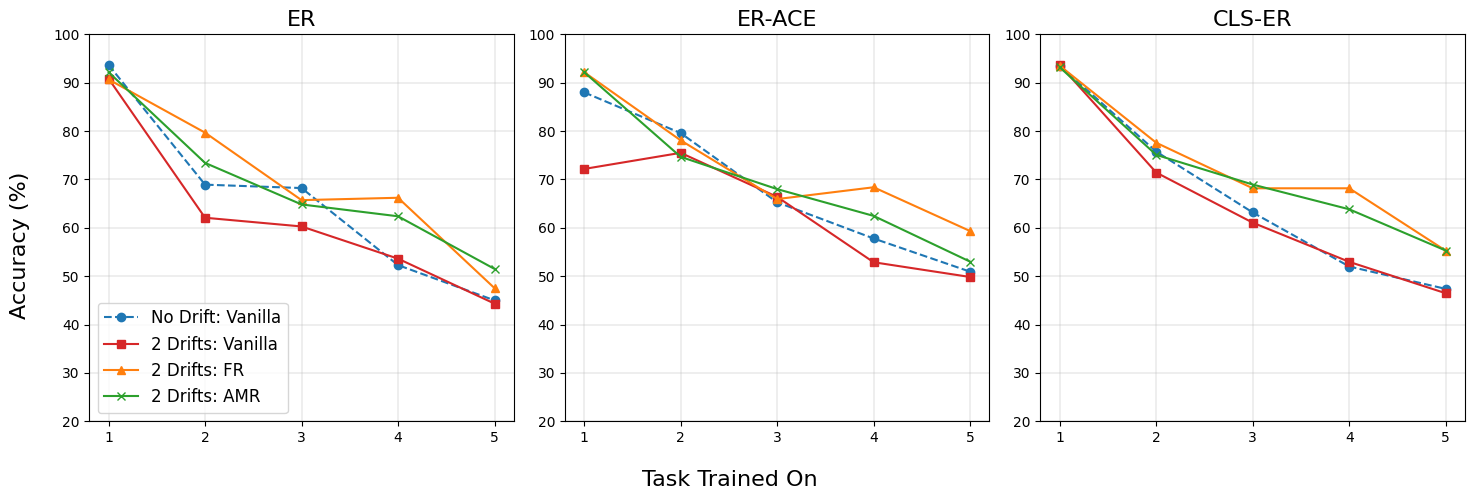

In [ ]:
plot_cumulative_subplots(
    [
        er_1000_accuracy_array_without_drift,
        er_1000_accuracy_array_with_drift,
        er_1000_accuracy_array_with_drift_full_relearning,
        er_1000_accuracy_array_with_drift_buffer_resampling,
        er_ace_1000_accuracy_array_without_drift,
        er_ace_1000_accuracy_array_with_drift,
        er_ace_1000_accuracy_array_with_drift_full_relearning,
        er_ace_1000_accuracy_array_with_drift_buffer_resampling,
        clser_1000_accuracy_array_without_drift,
        clser_1000_accuracy_array_with_drift,
        clser_1000_accuracy_array_with_drift_full_relearning,
        clser_1000_accuracy_array_with_drift_buffer_resampling,
    ],
    ["ER", "ER-ACE", "CLS-ER"],
    [
        "No Drift: Vanilla",
        "2 Drifts: Vanilla",
        "2 Drifts: FR",
        "2 Drifts: AMR",
    ],
    # plot_filename="CLEAR10_Buff_1000_n_2.pdf",
)